<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
!pip uninstall -y tensorflow 
!pip install tensorflow==2.4.3 > /dev/null 2>&1

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Tensorflow version 2.4.3
Running on TPU  ['10.118.127.186:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.118.127.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.118.127.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 140MB/s]
 92% 128M/139M [00:00<00:00, 128MB/s]
100% 139M/139M [00:00<00:00, 204MB/s]
 81% 61.0M/75.4M [00:00<00:00, 67.1MB/s]
100% 75.4M/75.4M [00:00<00:00, 139MB/s] 
Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [4]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

***

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

***
## data preparation

In [6]:
SEQ_LEN = 80

In [7]:
train_raw = pd.read_csv(f'{input_path}/train.csv')
test_raw = pd.read_csv(f'{input_path}/test.csv')
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

In [8]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )

In [9]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

train = add_features(train_raw)
test = add_features(test_raw)

In [10]:
# def compute_feats(dataframe):
#     dataframe = dataframe.copy()

#     # time features
#     dataframe["time_diff"] = dataframe.groupby("breath_id")["time_step"].diff()
#     dataframe['time_since_expiratory']= dataframe['time_step'] * dataframe['u_out']

#     # lag features
#     lags = [1,2]
#     for lag in lags:
#         dataframe[f"u_in_lag{lag}"] = dataframe.groupby("breath_id")["u_in"].shift(lag).fillna(0)

#     # stats on u_in
#     dataframe["u_in_cumsum"] = dataframe.groupby("breath_id")["u_in"].cumsum()
#     dataframe['u_in_cummean'] =dataframe['u_in_cumsum'] / (dataframe.groupby("breath_id")["id"].cumcount()+1)
#     #dataframe['u_in_last'] = dataframe.groupby('breath_id')['u_in'].transform('last')
#     dataframe['cross1']= dataframe['u_in'] * dataframe['u_out']
#     dataframe['cross2']= dataframe['u_in'] * (1 - dataframe['u_out'])

#     dataframe['area'] = dataframe['time_step'] * dataframe['u_in']
#     dataframe['area'] = dataframe.groupby('breath_id')['area'].cumsum()
    
#     dataframe['vol_diff'] = (dataframe['time_diff']*dataframe['u_in']).fillna(0)
#     dataframe['vol_diff_cumsum'] = dataframe.groupby('breath_id')['vol_diff'].cumsum()

#     # gradients of u_in
#     def compute_grad_1st(df):
#         return np.gradient(df.u_in, 100*df.time_step)
#     def compute_grad_2nd(df):
#         return np.gradient(df.grad_1st, 100*df.time_step)

#     gb_result = dataframe.groupby("breath_id").apply(compute_grad_1st)
#     dataframe["grad_1st"] = np.concatenate(gb_result.values)
#     gb_result = dataframe.groupby("breath_id").apply(compute_grad_2nd)
#     dataframe["grad_2nd"] = np.concatenate(gb_result.values)

#     # nan filling
#     dataframe["time_diff"] = dataframe["time_diff"].fillna(method="bfill")
    
#     # ohe of R&C values    
#     dataframe['R'] = dataframe['R'].astype(str)
#     dataframe['C'] = dataframe['C'].astype(str)
#     dataframe['RC'] = dataframe['R']+dataframe['C']
#     dataframe = pd.get_dummies(dataframe)
#     return dataframe

# train = compute_feats(train_raw)
# test  = compute_feats(test_raw)

In [11]:
targets = train[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

cols_to_exclude_train = exclude = ["id","breath_id","pressure"]
cols_to_exclude_test = exclude = ["id","breath_id",]

train.drop(cols_to_exclude_train, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

In [12]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [13]:
train = train.reshape(-1, SEQ_LEN, train.shape[-1])
test = test.reshape(-1, SEQ_LEN, train.shape[-1])

***
## model training

In [14]:
def build_model(input_dim):
    with tpu_strategy.scope():   
        inputs = layers.Input(shape = input_dim)

        #h1 = layers.Dense(256, activation = 'selu')(inputs)
        #h2 = layers.Dense(512, activation = 'selu')(h1)
        #h3 = layers.Dense(1024, activation = 'swish')(h2)
    
        h1 = layers.Bidirectional(layers.LSTM(1024, return_sequences=True, recurrent_dropout=0.1))(inputs)
        h2 = layers.Bidirectional(layers.LSTM(512, return_sequences=True, recurrent_dropout=0.1))(h1)
        h3 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, recurrent_dropout=0.1))(h2)
        h4 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, recurrent_dropout=0.1))(h3)
 
        #h4 = layers.Add()([h2,h4])
        #h5 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(h4) 

        #hcat = layers.Concatenate()([h4,h6])
        #hcat = layers.Dropout(0.1)(hcat)

        out = layers.Dense(128, activation = 'selu')(h4)
        out = layers.Dense(1)(out)
        
        model = keras.Model(inputs, out)
        model.compile(optimizer="adam", loss="mae")
           
    return model  

In [15]:
# def build_model(input_dim):
#     with tpu_strategy.scope():   
#         inputs = layers.Input(shape = input_dim)
    
#         h1 = layers.Bidirectional(layers.LSTM(384, return_sequences=True, ))(inputs)
#         h2 = layers.Bidirectional(layers.LSTM(384, return_sequences=True, ))(h1)
#         h3 = layers.Bidirectional(layers.LSTM(384, return_sequences=True, ))(h2)
#         h4 = layers.Bidirectional(layers.LSTM(384, return_sequences=True, ))(h3) 

#         m1 = layers.Bidirectional(layers.LSTM(1, return_sequences=True))(inputs)
#         m1 = tf.math.reduce_sum(m1, axis=2, keepdims=True)
#         m2 = layers.Bidirectional(layers.LSTM(1, return_sequences=True))(inputs)
#         m2 = tf.math.reduce_sum(m2, axis=2, keepdims=True)
#         m3 = layers.Bidirectional(layers.LSTM(1, return_sequences=True))(inputs)
#         m3 = tf.math.reduce_sum(m3, axis=2, keepdims=True)
#         m4 = layers.Bidirectional(layers.LSTM(1, return_sequences=True))(inputs)
#         m4 = tf.math.reduce_sum(m4, axis=2, keepdims=True)

#         logits = tf.concat([m1,m2,m3,m4], axis=2)
#         att = tf.nn.softmax(logits, axis=2)

#         hidden = h1*tf.expand_dims(att[:,:,0], axis=2) + h2*tf.expand_dims(att[:,:,1], axis=2) + h3*tf.expand_dims(att[:,:,2], axis=2) + h4*tf.expand_dims(att[:,:,3], axis=2)

#         out = layers.Dense(128, activation = 'selu')(hidden)
#         out = layers.Dense(1)(out)
        
#         model = keras.Model(inputs, out)
#         model.compile(optimizer="adam", loss="mae")
           
#     return model 

----------------------------------- Fold: 1 ------------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 256)           656384    
_________________________________________________________________
dense (Dense)                (None, 80, 128)           32896     
______________________________________________

None

Epoch 1/300
59/59 [==============================] - 86s 871ms/step - loss: 4.6532 - val_loss: 1.8586
Epoch 2/300
59/59 [==============================] - 20s 340ms/step - loss: 1.4670 - val_loss: 0.8977
Epoch 3/300
59/59 [==============================] - 20s 340ms/step - loss: 0.8540 - val_loss: 0.7098
Epoch 4/300
59/59 [==============================] - 20s 341ms/step - loss: 0.7127 - val_loss: 0.5923
Epoch 5/300
59/59 [==============================] - 20s 340ms/step - loss: 0.6231 - val_loss: 0.6667
Epoch 6/300
59/59 [==============================] - 20s 340ms/step - loss: 0.6196 - val_loss: 0.5494
Epoch 7/300
59/59 [==============================] - 20s 341ms/step - loss: 0.5376 - val_loss: 0.5474
Epoch 8/300
59/59 [==============================] - 20s 340ms/step - loss: 0.5025 - val_loss: 0.4636
Epoch 9/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4787 - val_loss: 0.4388
Epoch 10/300
59/59 [==============================] - 20s 341ms/step - loss: 0.475

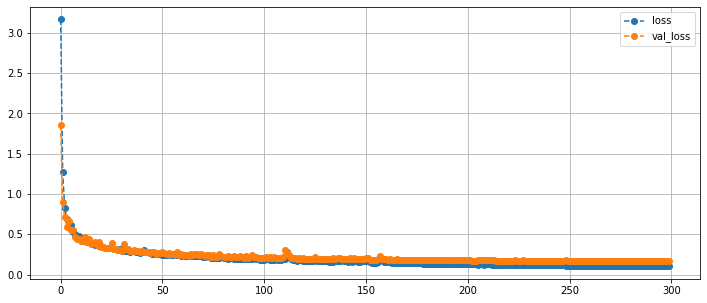

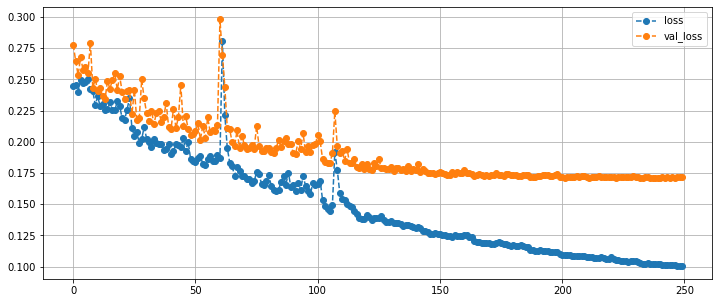

----------------------------------- Fold: 2 ------------------------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 80, 256)           656384    
_________________________________________________________________
dense_2 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 87s 888ms/step - loss: 4.3588 - val_loss: 1.3749
Epoch 2/300
59/59 [==============================] - 20s 340ms/step - loss: 1.2373 - val_loss: 0.9851
Epoch 3/300
59/59 [==============================] - 20s 340ms/step - loss: 0.7927 - val_loss: 0.6620
Epoch 4/300
59/59 [==============================] - 20s 340ms/step - loss: 0.6430 - val_loss: 0.5544
Epoch 5/300
59/59 [==============================] - 20s 340ms/step - loss: 0.5754 - val_loss: 0.5041
Epoch 6/300
59/59 [==============================] - 20s 340ms/step - loss: 0.5140 - val_loss: 0.4821
Epoch 7/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4790 - val_loss: 0.4358
Epoch 8/300
59/59 [==============================] - 20s 347ms/step - loss: 0.4422 - val_loss: 0.4112
Epoch 9/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4184 - val_loss: 0.4422
Epoch 10/300
59/59 [==============================] - 20s 340ms/step - loss: 0.408

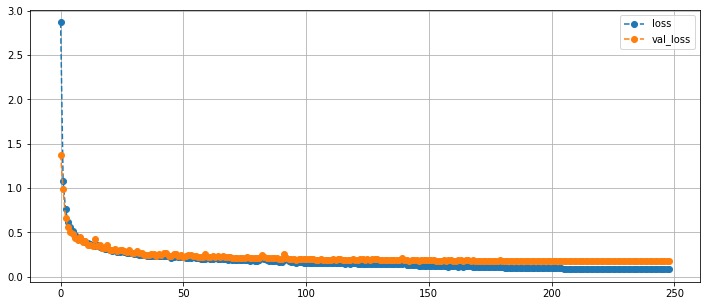

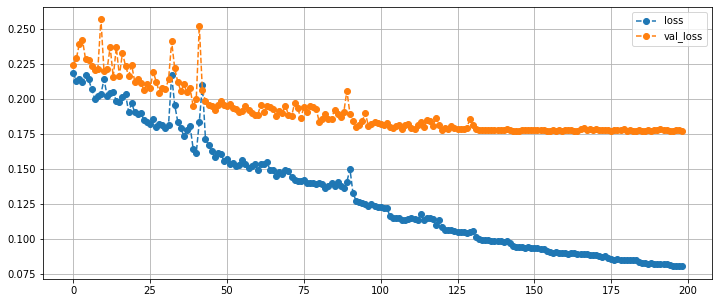

----------------------------------- Fold: 3 ------------------------------------
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_4 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 86s 868ms/step - loss: 4.1167 - val_loss: 1.2620
Epoch 2/300
59/59 [==============================] - 20s 341ms/step - loss: 1.1456 - val_loss: 0.7418
Epoch 3/300
59/59 [==============================] - 20s 341ms/step - loss: 0.7502 - val_loss: 0.5916
Epoch 4/300
59/59 [==============================] - 20s 341ms/step - loss: 0.6319 - val_loss: 0.5380
Epoch 5/300
59/59 [==============================] - 20s 341ms/step - loss: 0.5474 - val_loss: 0.5064
Epoch 6/300
59/59 [==============================] - 20s 341ms/step - loss: 0.5602 - val_loss: 0.4889
Epoch 7/300
59/59 [==============================] - 20s 342ms/step - loss: 0.4617 - val_loss: 0.4596
Epoch 8/300
59/59 [==============================] - 20s 343ms/step - loss: 0.4435 - val_loss: 0.4466
Epoch 9/300
59/59 [==============================] - 20s 343ms/step - loss: 0.4296 - val_loss: 0.4618
Epoch 10/300
59/59 [==============================] - 20s 343ms/step - loss: 0.406

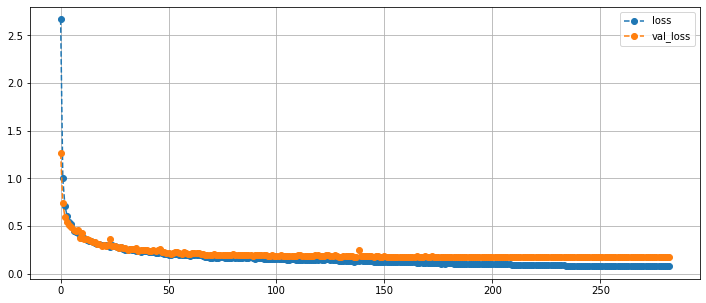

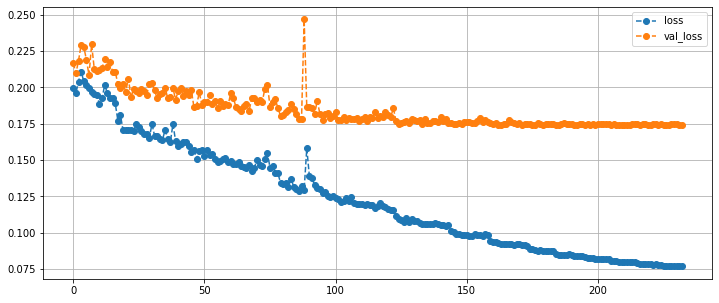

----------------------------------- Fold: 4 ------------------------------------
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_6 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 88s 904ms/step - loss: 4.4026 - val_loss: 1.4500
Epoch 2/300
59/59 [==============================] - 20s 340ms/step - loss: 1.1533 - val_loss: 0.8392
Epoch 3/300
59/59 [==============================] - 20s 340ms/step - loss: 0.7638 - val_loss: 0.6917
Epoch 4/300
59/59 [==============================] - 20s 340ms/step - loss: 0.6415 - val_loss: 0.5785
Epoch 5/300
59/59 [==============================] - 20s 340ms/step - loss: 0.5870 - val_loss: 0.5450
Epoch 6/300
59/59 [==============================] - 20s 340ms/step - loss: 0.5147 - val_loss: 0.5139
Epoch 7/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4759 - val_loss: 0.4730
Epoch 8/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4544 - val_loss: 0.4504
Epoch 9/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4431 - val_loss: 0.4108
Epoch 10/300
59/59 [==============================] - 20s 340ms/step - loss: 0.430

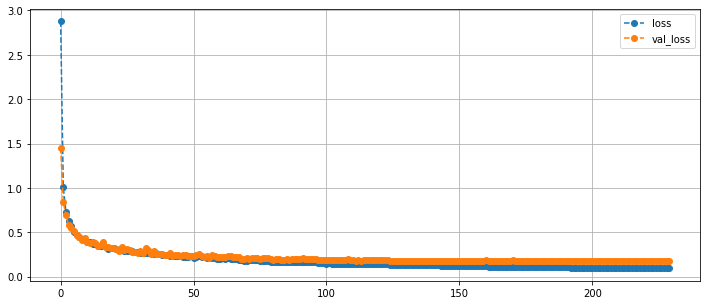

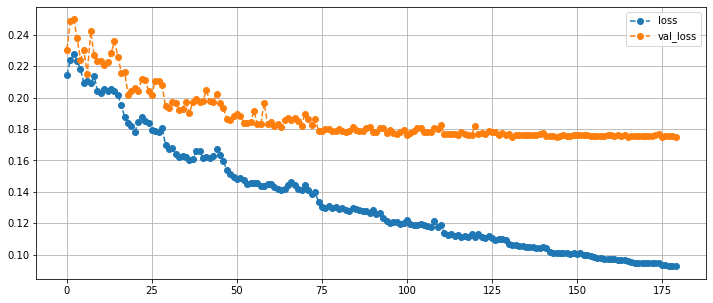

----------------------------------- Fold: 5 ------------------------------------
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_8 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
59/59 [==============================] - 88s 891ms/step - loss: 4.2876 - val_loss: 2.1330
Epoch 2/300
59/59 [==============================] - 20s 340ms/step - loss: 1.3641 - val_loss: 0.9479
Epoch 3/300
59/59 [==============================] - 20s 340ms/step - loss: 0.8185 - val_loss: 0.7160
Epoch 4/300
59/59 [==============================] - 20s 340ms/step - loss: 0.6531 - val_loss: 0.5617
Epoch 5/300
59/59 [==============================] - 20s 340ms/step - loss: 0.5836 - val_loss: 0.4998
Epoch 6/300
59/59 [==============================] - 20s 340ms/step - loss: 0.5297 - val_loss: 0.4888
Epoch 7/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4816 - val_loss: 0.4947
Epoch 8/300
59/59 [==============================] - 20s 341ms/step - loss: 0.4521 - val_loss: 0.4792
Epoch 9/300
59/59 [==============================] - 20s 340ms/step - loss: 0.4469 - val_loss: 0.3985
Epoch 10/300
59/59 [==============================] - 20s 340ms/step - loss: 0.403

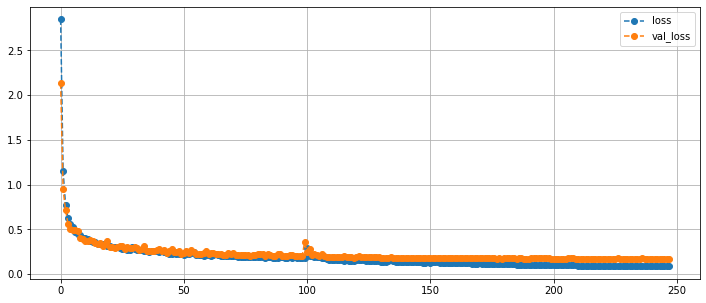

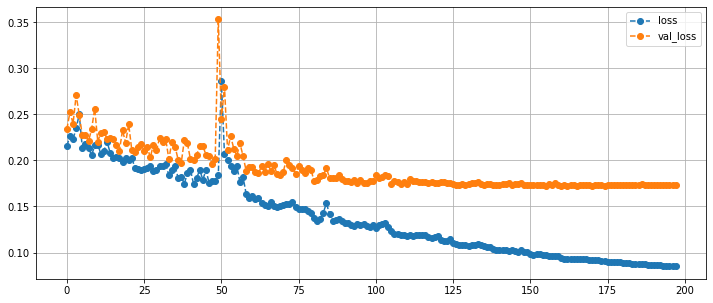

In [16]:
EPOCH = 300
BATCH_SIZE = 1024

kf = KFold(n_splits=5, shuffle=True, random_state=19)
models_by_fold = list()

oof = train_raw[["id","breath_id","u_out","pressure"]].copy()

for fold, (train_idx,valid_idx) in enumerate(kf.split(train, targets)):

    print(f" Fold: {fold+1} ".center(80, "-"))
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = targets[train_idx], targets[valid_idx]
    
    model = build_model(input_dim=train.shape[-2:])
    display(model.summary())

    #scheduler = ExponentialDecay(
    #    initial_learning_rate=1e-3, 
    #    decay_steps=EPOCH*((len(train)*0.8)/BATCH_SIZE), 
    #    decay_rate=1e-5
    #)
    #lr = LearningRateScheduler(scheduler, verbose=1)
    #lr = OneCycleScheduler(
    #    lr_max = 1e-3,
    #    steps = EPOCH*(X_train.shape[0]/BATCH_SIZE),
    #    phase_1_pct = 0.2,
    #    init_div_factor = 1e1,
    #    final_div_factor = 1e2,
    #)

    lr = ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.8, 
        patience=10, 
        verbose=1
    )
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=35, 
        verbose=1,
        restore_best_weights=True,
    )
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        callbacks=[lr,es],
        verbose=1,
    )
    models_by_fold.append(model)

    # generate the oof predictions
    x_valid_tf = tf.convert_to_tensor(X_valid, dtype=tf.float32)
    oof_preds = model.call(x_valid_tf, training=False).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()

    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"], "o--", label="loss")
    plt.plot(history.history["val_loss"], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"][50:], "o--", label="loss")
    plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()


In [17]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.17110353834650535
mae inspiratory: 0.18361930380653205
mae expiratory : 0.1634472037239466


Ideas that worked:
- (recurrent_dropout=0.1) 1024-512-256-128 -> 0.1707
- (recurrent_dropout=0.1) 512-512-256-256  -> 0.1724
- (recurrent_dropout=0.1) 512-512-512-512 -> 0.1730
- lstm with att 384-384-384-384           -> 0.1747
- (recurrent_dropout=0.2) 1024-512-256-128 -> 0.1719


lstm_v7
- mae: 0.17478381765716353
- mae inspiratory: 0.1884791864930153
- mae expiratory : 0.16640587809591878

lstm_v6
- mae: 0.1700748569735916
- mae inspiratory: 0.18324426831174476
- mae expiratory : 0.16202780215683016

lstm_v5
- mae: 0.19870362716674497
- mae inspiratory: 0.24693164942887788
- mae expiratory : 0.169200847028661

lstm_v4
- mae: 0.19910630745529212
- mae inspiratory: 0.24139623415898287
- mae expiratory : 0.1732360695506279

lstm_v3
- mae: 0.1894350191416654
- mae inspiratory: 0.22527142074094628
- mae expiratory : 0.16751262988059495

lstm_v2
- mae: 0.20938487189579605
- mae inspiratory: 0.2124941942660988
- mae expiratory : 0.19958701148249222

lstm_v1
- mae: 0.18086928169783648
- mae inpiratory: 0.2031012730817264
- mae expiratory: 0.16726918940573152

***
## sub generation

In [29]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in models_by_fold:
    preds = model.call(test_tf, training=False).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.median(all_preds, axis=0)

In [30]:
# saves final sub
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_lstm.csv", index=False)

# clip predictions to discrete values
all_pressure = np.sort(train_raw.pressure.unique())
PRESSURE_MIN = all_pressure[0]
PRESSURE_MAX = all_pressure[-1]
PRESSURE_STEP = all_pressure[1]-all_pressure[0]

sub["pressure"] =\
    np.round( (sub.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
sub.pressure = np.clip(sub.pressure, PRESSURE_MIN, PRESSURE_MAX)
sub.to_csv(f"{subs_path}/sub_lstm_clip.csv", index=False)

In [31]:
# saves oof preds
oof.to_csv(f"{results_path}/oof_lstm.csv", index=False)

In [32]:
# saves each model preds (pseudo labels)
for fold,preds in enumerate(all_preds):
    _sub = submission.copy()
    _test = test_raw[["id","pressure"]].copy()
    _test["pressure"] = preds
    _sub = pd.merge(_sub["id"], _test[["id","pressure"]], how="left", on="id")
    _sub["pressure"] = _sub["pressure"].fillna(0)
    _sub.to_csv(f"{results_path}/plabels_lstm_{fold}.csv", index=False)

***